In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv(r"C:\Users\Admin\Data python\data_all\data_all\train.csv")
pd.set_option('display.max_columns', 32)
data.head()

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
0,1,Resort Hotel,0,1,0,1,2,0.0,1,BB,PRT,Direct,Direct,0,0,0,A,A,1,250.0,0.0,0,Transient,55.00,1,0,2017-02-04
1,2,Resort Hotel,0,1,0,2,1,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,D,0,0.0,0.0,0,Transient,40.00,0,0,2016-03-04
2,3,City Hotel,1,56,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,29.0,0.0,0,Transient,60.00,0,0,2017-02-01
3,4,City Hotel,0,213,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,9.0,0.0,0,Transient,102.85,0,1,2016-10-05
4,5,Resort Hotel,0,328,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,243.0,0.0,0,Contract,121.50,0,2,2017-06-29


In [3]:
col = ['agent', 'company', 'id', "hotel", 'arrival_date']

hotel_book = data.drop(col, axis= 1)

In [4]:
hotel_book.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000
mean,0.370685,100.159847,0.909445,2.464935,1.845264,0.092375,0.007951,0.032541,0.094406,0.136958,0.211748,2.540249,97.085407,0.063097,0.544239
std,0.482991,104.953130,0.992503,1.887034,0.582494,0.377309,0.098157,0.177433,0.881879,1.448224,0.626862,18.401511,46.910659,0.246518,0.777150
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,17.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.500000,0.000000,0.000000
50%,0.000000,65.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000
75%,1.000000,152.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,0.000000,1.000000
max,1.000000,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,67.000000,18.000000,391.000000,5400.000000,8.000000,5.000000


## Explain column meaning

**hotel**：City hotel hoặc Resort Hotel

**lead_time**：Số ngày từ khi đặt phòng đến ngày nghỉ trọ.

**stays_in_weekend_nights**：Số ngày đặt phòng và nghỉ lại (Thứ 7, Chủ Nhật)

**stays_in_week_nights**：Số ngày đặt phòng và nghỉ lại (Thứ 2 ~ Thứ 6)

**country**：Quốc gia.

**market_segment**：Phân loại thị trường(TA：Đại lý du lịch、TO：Điều hành du lịch)

**distribution_channel**：kênh cung cấp(TA：Đại lý du lịch、TO：Điều hành du lịch)

**is_repeated_guest**：có phải repeater hay không

**previous_cancellations**：Đã từng hủy đặt phòng trước đây

**previous_bookings_not_canceled**：chưa từng hủy đặt phòng trước đây

**reserved_room_type**：Loại phòng đặt

**assigned_room_type**：Loại phòng sắp xếp

**booking_changes**：Số lần thay đổi đặt phòng

**agent**：ẩn

**company**：ẩn

**days_in_waiting_list**：Số ngày lấy được xác nhận của khách hàng.

**customer_type**：loại khách hàng

**adr**：Tỉ giá trung bình ngày nghỉ trọ

**required_car_parking_spaces**：Yêu cầu bao nhiêu chỗ đỗ xe

**total_of_special_requests**：Số lượng yêu cầu đặc biệt.

*Đây là bộ dữ liệu trích xuất từ hệ thống Quản lý khách sạn (PMS), vì thế tên khách sạn và đại lý đặt phòng sẽ được ẩn 
đi.*

### Explain for meal

**RO**: Room only

**BB**: Bed & Breakfast

**HB**: Half Board (Breakfast and Dinner normally)

**FB**: Full Board (Beakfast, Lunch and Dinner)

**AI**: All Inclusive (all services of full board plus any others specified in each case)

In [5]:
# Categorical data
col = ['meal', 'country',"market_segment", 'distribution_channel', 'reserved_room_type', 'assigned_room_type',"customer_type"]

for i in hotel_book[col]:
    x = hotel_book[i].value_counts()
    print("Column name is:",i,"and it value is:",x)
    print()

Column name is: meal and it value is: BB    85099
HB    12705
SC    10238
FB      743
Name: meal, dtype: int64

Column name is: country and it value is: PRT    45865
GBR    10764
FRA     9498
ESP     7614
DEU     6387
       ...  
VGB        1
BHS        1
FJI        1
KNA        1
MMR        1
Name: country, Length: 173, dtype: int64

Column name is: market_segment and it value is: Online TA        49545
Offline TA/TO    22682
Groups           19354
Direct           11196
Corporate         5079
Complementary      697
Aviation           230
Undefined            2
Name: market_segment, dtype: int64

Column name is: distribution_channel and it value is: TA/TO        88940
Direct       13203
Corporate     6449
GDS            188
Undefined        5
Name: distribution_channel, dtype: int64

Column name is: reserved_room_type and it value is: A    79728
D    16771
E     5708
F     2536
G     1796
B     1041
C      689
H      510
L        6
Name: reserved_room_type, dtype: int64

Column name 

**meal country**:5

**market_segment**: 177

**market_segment**: 8 

**distribution_channel**: 5 

**reserved_room_type**: 9

**assigned_room_type**: 11

**deposit_type**: 3

**customer_type**: 4

In [6]:
hotel_book.isnull().any()

is_canceled                       False
lead_time                         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
days_in_waiting_list              False
customer_type                     False
adr                               False
required_car_parking_spaces       False
total_of_special_requests         False
dtype: bool

In [7]:
index_drop1 = list(hotel_book[(hotel_book["stays_in_weekend_nights"] == 0) & 
                          (hotel_book["stays_in_week_nights"] == 0)].index)
index_drop2 = list(hotel_book[hotel_book["adr"] == 0].index)

index_drop3 = list(hotel_book[(hotel_book['market_segment'] == 'Undefined') & 
                               (hotel_book['distribution_channel'] == 'Undefined')].index)

index_drop = index_drop1 + index_drop2 + index_drop3

hotel_book = hotel_book.drop(index_drop, axis = 0)

In [8]:
cat_attri = ['meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', "customer_type"]

one_hot = pd.get_dummies(hotel_book[cat_attri])
hotel_book = hotel_book.drop(cat_attri, axis = 1)
# Join the encoded df
hotel_book = hotel_book.join(one_hot)
hotel_book

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,...,reserved_room_type_L,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,1,0,1,2,0.0,1,0,0,0,1,0,55.00,1,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,2,1,0.0,0,0,0,0,0,0,40.00,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,1,56,0,3,2,0.0,0,0,0,0,0,0,60.00,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,213,2,5,2,0.0,0,0,0,0,0,0,102.85,0,1,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,328,4,10,2,0.0,0,0,0,0,0,0,121.50,0,2,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108780,1,37,0,3,2,0.0,0,0,0,0,0,0,105.00,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
108781,0,13,1,2,2,0.0,0,0,0,0,0,0,82.00,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
108782,0,124,0,3,2,0.0,0,0,0,0,2,0,126.00,0,1,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
108783,1,130,2,5,2,0.0,0,0,0,0,0,0,120.60,0,2,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 2, n_init = 4)

gm.fit(hotel_book)

densities = gm.score_samples(hotel_book)

density_thresholds = np.percentile(densities, 5)

hotel_book_no_anomalies = hotel_book[densities > density_thresholds]

In [10]:
x_train = hotel_book_no_anomalies.drop(['is_canceled'], axis = 1)
y_train = hotel_book_no_anomalies['is_canceled'].copy()

In [11]:
from sklearn.preprocessing import StandardScaler

X_train_prepared = StandardScaler().fit_transform(x_train)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)

X_train_reduced = pca.fit_transform(X_train_prepared)

In [12]:
X_train_reduced.shape

NameError: name 'X_train_reduced' is not defined

In [14]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def EvalAcc_Confumatrix(model, X, Y, cv = 5):
    result1 = cross_val_score(model, X, Y, scoring = "accuracy", cv = cv)
    result2 = cross_val_predict(model, X, Y, cv = cv)
    print("score_accuracy:", result1)
    print("confu_matrix:", confusion_matrix(Y, result2))
    print("precision_score:", precision_score(Y, result2))
    print("recall_score:", recall_score(Y, result2))
    tn = confusion_matrix(result2, Y).ravel()
    return tn

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

def EvalROCcurve_Plot(model, X, Y, cv = 5, method = "decision_function", 
                      styleplot = "seaborn", titleplot1 = None, titleplot2 = None):
    method = method
    y_s = cross_val_predict(model, X, Y, cv = cv, method = method, verbose = 2)
    # Choose column if method is predict proba
    if (method == "predict_proba"):
        y_score = y_s[:, 1]
    else:
        y_score = y_s
    # Caculate precision, recall and thresholds
    precisions, recalls, thresholds1 = precision_recall_curve(Y, y_score)
    # Caculate ROC AUC
    RocAucScore = roc_auc_score(Y, y_score)
    fpr, tpr, thresholds2 = roc_curve(Y, y_score)
    with plt.style.context(styleplot):
        fig, ax = plt.subplots(2, 1, figsize = (13, 10))
        # Plot Roc_curve
        ax[0].plot(fpr, tpr, linewidth = 2)
        ax[0].plot([0, 1], [0, 1], "k--")
        ax[0].set(xlabel = "False Positive Rate", ylabel  = "Recall", title = titleplot1)
        # Plot precision and recall curve
        ax[1].plot(thresholds1, precisions[:-1], "b--", label = "Precision", linewidth = 2)
        ax[1].plot(thresholds1, recalls[:-1], "g--", label = "Recall", linewidth = 2)
        ax[1].set(xlabel = "Thresholds", title = titleplot2)
        ax[1].legend(prop={'size': 15})
    print("ROC AUC:", RocAucScore)
    return fpr, tpr, thresholds1

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)

sgd_confu = EvalAcc_Confumatrix(sgd_clf, X_train_reduced, y_train)

score_accuracy: [0.79998033 0.79880028 0.80229128 0.8027241  0.80247824]
confu_matrix: [[55749  6971]
 [13239 25729]]
precision_score: 0.7868195718654434
recall_score: 0.6602597002668856


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s finished
ROC AUC: 0.8732945529580263


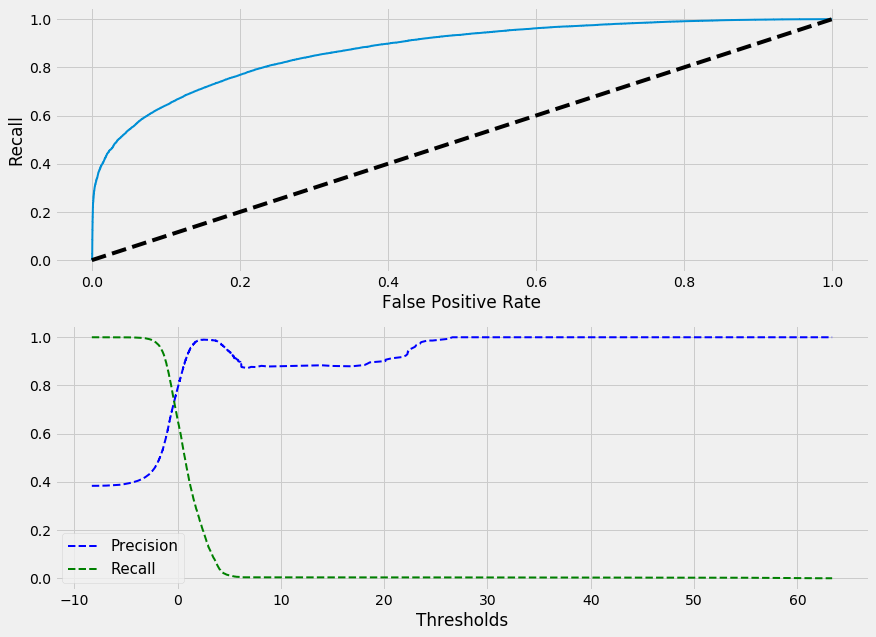

In [17]:
sgd_ROC = EvalROCcurve_Plot(sgd_clf, X_train_reduced, y_train, styleplot = "fivethirtyeight")

In [18]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42)

rand_forest = EvalAcc_Confumatrix(random_clf, X_train_reduced, y_train)

score_accuracy: [0.8676861  0.87137378 0.8697512  0.8711216  0.87107243]
confu_matrix: [[57975  4745]
 [ 8454 30514]]
precision_score: 0.865424430641822
recall_score: 0.7830527612399918


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.3min finished
ROC AUC: 0.9388136455222679


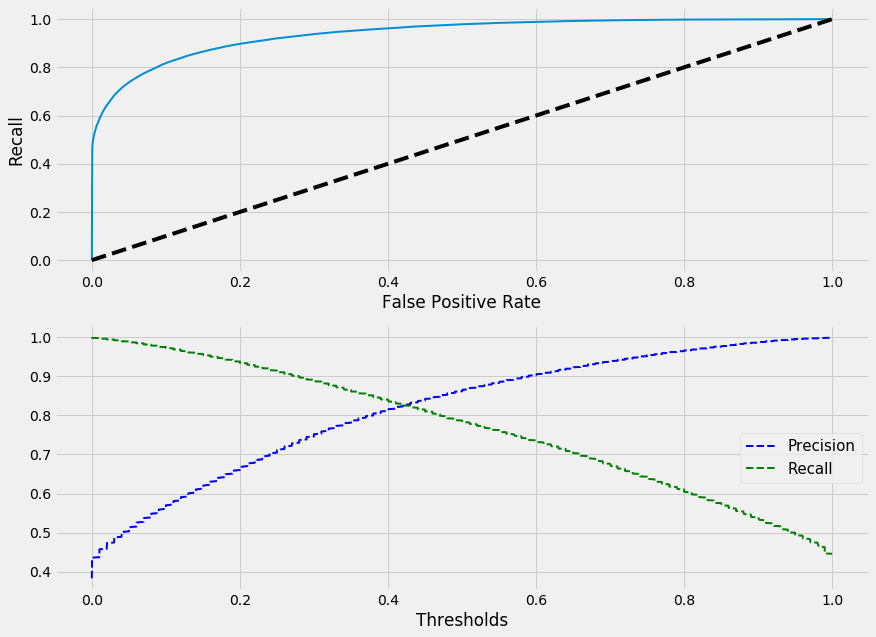

In [19]:
rand_forest_roc = EvalROCcurve_Plot(random_clf, X_train_reduced, y_train, method = "predict_proba", styleplot = "fivethirtyeight")